In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
import torch
print(torch.__version__)


2.5.1+cu118


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [4]:
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

NVIDIA GeForce RTX 4060 Laptop GPU


In [5]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

# print("Path to dataset files:", path)

In [6]:
# import os
# print("Files in the dataset directory:", os.listdir(path))

In [7]:
# ['glioma', 'meningioma', 'notumor', 'pituitary']

In [8]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Transform (resize + convert to tensor)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset
train_dataset = datasets.ImageFolder(root="D:\Programming\Cancer_Detection_Model\Brain_Tumor_Model\Data\Training", transform=transform)

# Class names
classes = train_dataset.classes
print("Classes:", classes)


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


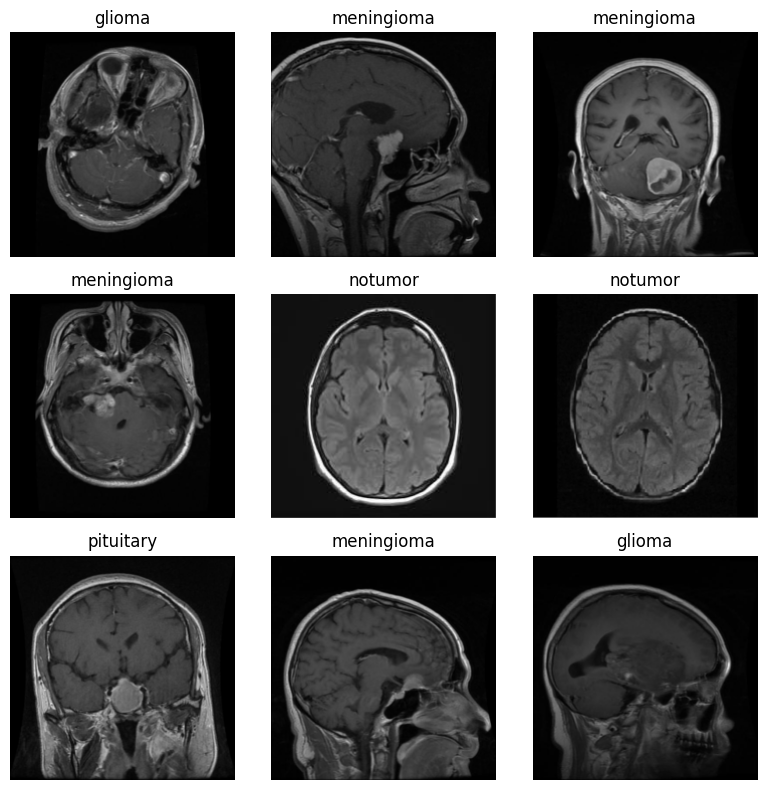

In [9]:
import random
import numpy as np

# Pick 9 random images
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i in range(9):
    idx = random.randint(0, len(train_dataset)-1)
    img, label = train_dataset[idx]

    # Tensor → Numpy for plotting
    img = img.permute(1, 2, 0).numpy()
    
    ax = axes[i//3, i%3]
    ax.imshow(img)
    ax.set_title(classes[label])
    ax.axis("off")

plt.tight_layout()
plt.show()



In [10]:
from collections import Counter

# Folder-wise image counts
labels = [label for _, label in train_dataset]
counter = Counter(labels)

for i, c in enumerate(classes):
    print(f"{c}: {counter[i]} images")


glioma: 1321 images
meningioma: 1339 images
notumor: 1595 images
pituitary: 1457 images


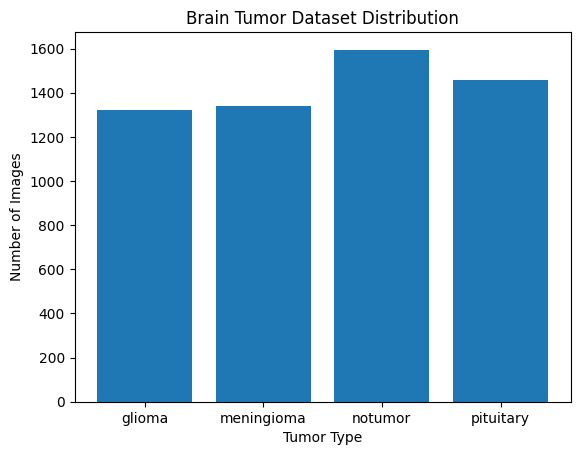

In [11]:
plt.bar(classes, [counter[i] for i in range(len(classes))])
plt.xlabel("Tumor Type")
plt.ylabel("Number of Images")
plt.title("Brain Tumor Dataset Distribution")
plt.show()


In [13]:
from torch.utils.data import DataLoader ,Dataset
from sklearn.model_selection import train_test_split



class CustomImageDataset(Dataset):
    def __init__(self, image_folder):
        self.image_folder = image_folder
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        
    def __len__(self):
        return len(self.image_folder)
    
    def __getitem__(self, idx):
        img, label = self.image_folder[idx]
        img = self.transform(img)
        return img, label

In [14]:
class CNN(torch.nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(64 * 56 * 56, 512)
        self.fc2 = torch.nn.Linear(512, num_classes)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
learning_rate = 0.001
num_epochs = 10
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
model = CNN(num_classes=len(classes)).to(device)